<a href="https://colab.research.google.com/github/rvedra/DadosDecis-oFGV/blob/main/Consumo_Horario_de_Energia_Setor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import zipfile
import os
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
## Configurando GPU para melhorar a performance do código.
import tensorflow as tf

try:
  physical_devices = tf.config.list_physical_devices('GPU')

  for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)
  print(physical_devices)
except:
  print("No GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Importando os dados
Etapa inicial buscando o arquivo com os dados de consumo de energia de 2019.
Dados foram retirados do site https://www.ccee.org.br/en/dados-e-analises/consumo para cada mês, e consolidado, filtrando apenas as unidades classificadas como "Consumidor Livre".

In [3]:
file_path = '/content/drive/MyDrive/Mestrado FGV/base_2019.parquet'

In [4]:
df = pd.read_parquet(file_path)

In [5]:
df.head()

,DATA,HH,Classe do perfil do agente,Nome Empresarial,CNPJ da Carga,Cidade,Estado,Submercado,Capacidade da Carga (MW),"Consumo no Ambiente Livre da parcela de carga - MWh (RC_AL c,j)",Ramo de Atividade
0,2019-01-01,15,Consumidor Livre,CONDOMÍNIO SP MARKET CENTER,1086381000136,SÃO PAULO,SP,SUDESTE,5.56,1.061488,SERVIÇOS
1,2019-01-01,16,Consumidor Livre,BRF S.A.,1838723000127,UBERLÂNDIA,MG,SUDESTE,8.70,1.493229,ALIMENTÍCIOS
2,2019-01-01,1,Consumidor Livre,BRF S.A.,1838723000127,UBERLÂNDIA,MG,SUDESTE,14.33,2.963599,ALIMENTÍCIOS
3,2019-01-01,9,Consumidor Livre,WHITE MARTINS GASES INDUSTRIAIS LTDA.,35820448000136,None,SP,SUDESTE,15.00,13.611115,QUÍMICOS
4,2019-01-01,3,Consumidor Livre,NOV FLEXIBLES EQUIPAMENTOS E SERVICOS LTDA.,13812133000376,SÃO JOÃO DA BARRA,RJ,SUDESTE,3.50,0.967662,MANUFATURADOS DIVERSOS


Conforme descrição dos dados abaixo, vamos remover a variável "Cidade", que apresenta muitos valores nulos, alem da "Classe do Perfil do Agente" e o "Nome Empresarial" já que não são variáveis relevantes.
Vemos que há uma forte assimetria nos dados da capacidade de carga, considerando que alguns valores que encontram-se acima do Percentil 75 podem ser outliers vão prejudicar a dispersão da amostra.

In [6]:
df.describe(include='all')

,DATA,HH,Classe do perfil do agente,Nome Empresarial,CNPJ da Carga,Cidade,Estado,Submercado,Capacidade da Carga (MW),"Consumo no Ambiente Livre da parcela de carga - MWh (RC_AL c,j)",Ramo de Atividade
count,18438271,1.843827e+07,18438271,18438271,18438271,16691723,18438271,18438271,1.843827e+07,1.843827e+07,18438271
unique,365,NaN,1,2525,2559,751,24,4,NaN,NaN,15
top,2019-12-11,NaN,Consumidor Livre,BRF S.A.,71832679000123,SÃO PAULO,SP,SUDESTE,NaN,NaN,ALIMENTÍCIOS
freq,55944,NaN,18438271,277495,140176,1041485,7073238,11805964,NaN,NaN,3307893
mean,NaN,1.150117e+01,NaN,NaN,NaN,NaN,NaN,NaN,1.171257e+01,6.262994e+00,NaN
std,NaN,6.922807e+00,NaN,NaN,NaN,NaN,NaN,NaN,2.890318e+01,1.949566e+01,NaN
min,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,6.000000e-01,0.000000e+00,NaN
25%,NaN,6.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,3.400000e+00,1.271760e+00,NaN
50%,NaN,1.200000e+01,NaN,NaN,NaN,NaN,NaN,NaN,4.950000e+00,2.720323e+00,NaN
75%,NaN,1.800000e+01,NaN,NaN,NaN,NaN,NaN,NaN,9.375000e+00,5.312434e+00,NaN


In [7]:
df = df.drop(['Nome Empresarial','Classe do perfil do agente','Cidade'], axis=1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18438271 entries, 0 to 18438270
Data columns (total 8 columns):
 #   Column                                                           Dtype  
---  ------                                                           -----  
 0   DATA                                                             object 
 1   HH                                                               int64  
 2   CNPJ da Carga                                                    object 
 3   Estado                                                           object 
 4   Submercado                                                       object 
 5   Capacidade da Carga (MW)                                         float64
 6   Consumo no Ambiente Livre da parcela de carga - MWh (RC_AL c,j)  float64
 7   Ramo de Atividade                                                object 
dtypes: float64(2), int64(1), object(5)
memory usage: 1.1+ GB


In [9]:
adjusted_column_names = {'DATA':'Data',
                        'HH':'Hora',
                        'CNPJ da Carga':'CNPJ',
                        'Ramo de Atividade':'Setor',
                        'Capacidade da Carga (MW)':'Capacidade_MW',
                        'Consumo no Ambiente Livre da parcela de carga - MWh (RC_AL c,j)':'Consumo Horario_MWh'}

df_ml = df.rename(columns=adjusted_column_names)

Conforme indicado acima, há um indicativo forte de que a amostra apresenta outliers, que deverão ser tratados em etapa posterior.

{'whiskers': [<matplotlib.lines.Line2D at 0x7a69bc2f71c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7a69bc2f7730>,
 'boxes': [<matplotlib.lines.Line2D at 0x7a69bc2f6f80>],
 'medians': [<matplotlib.lines.Line2D at 0x7a69bc2f7c70>],
 'fliers': [<matplotlib.lines.Line2D at 0x7a69bc2f7f10>],
 'means': []}

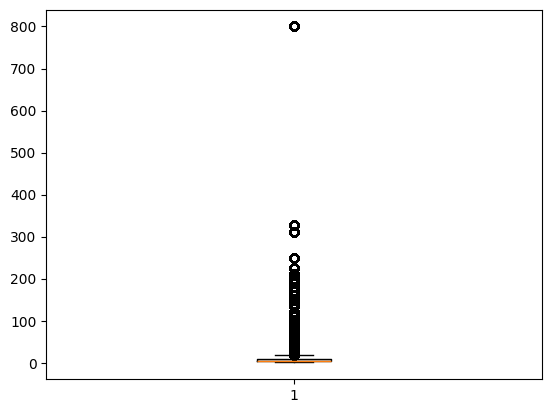

In [10]:
plt.boxplot(df_ml['Capacidade_MW'])

<Axes: title={'center': 'Quantidade de empresas por setor'}, xlabel='Setor'>

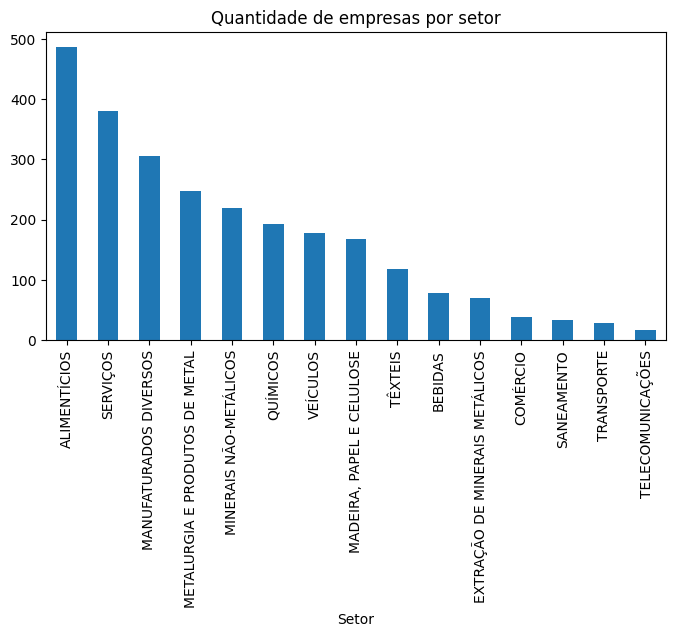

In [11]:
qtd_por_setor = df_ml[['CNPJ','Setor']].groupby('CNPJ').first()['Setor'].value_counts()
qtd_por_setor.plot(kind='bar', figsize=(8,4), title='Quantidade de empresas por setor')


In [12]:
df_ml[['Capacidade_MW','Consumo Horario_MWh']].corr()

,Capacidade_MW,Consumo Horario_MWh
Capacidade_MW,1.000000,0.800951
Consumo Horario_MWh,0.800951,1.000000


<Axes: xlabel='Data,Hora'>

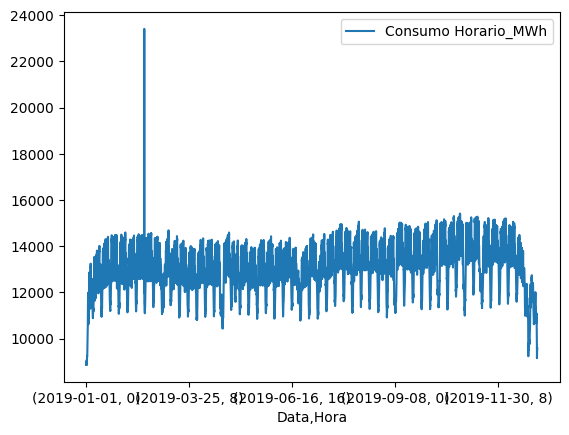

In [13]:
perfil_consumo = df_ml[['Data','Hora','Consumo Horario_MWh']].groupby(['Data','Hora']).sum()
perfil_consumo.plot()

<Axes: title={'center': 'Capacidade individual média por setor (MW)'}, xlabel='Setor'>

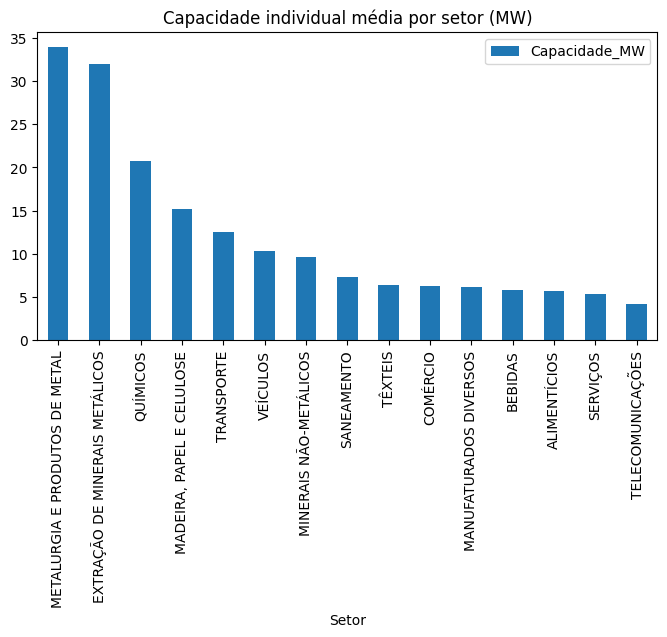

In [14]:
df_ml[['Setor','Capacidade_MW']].groupby(by='Setor').mean().sort_values(by='Capacidade_MW',
                                                                        ascending=False).plot(kind='bar',
                                                                                              figsize=(8,4),
                                                                                              title='Capacidade individual média por setor (MW)')

In [15]:
consumo_setor = df_ml[['Consumo Horario_MWh','Data','Setor']].groupby(['Setor','Data']).sum().reset_index()

<Axes: xlabel='Data'>

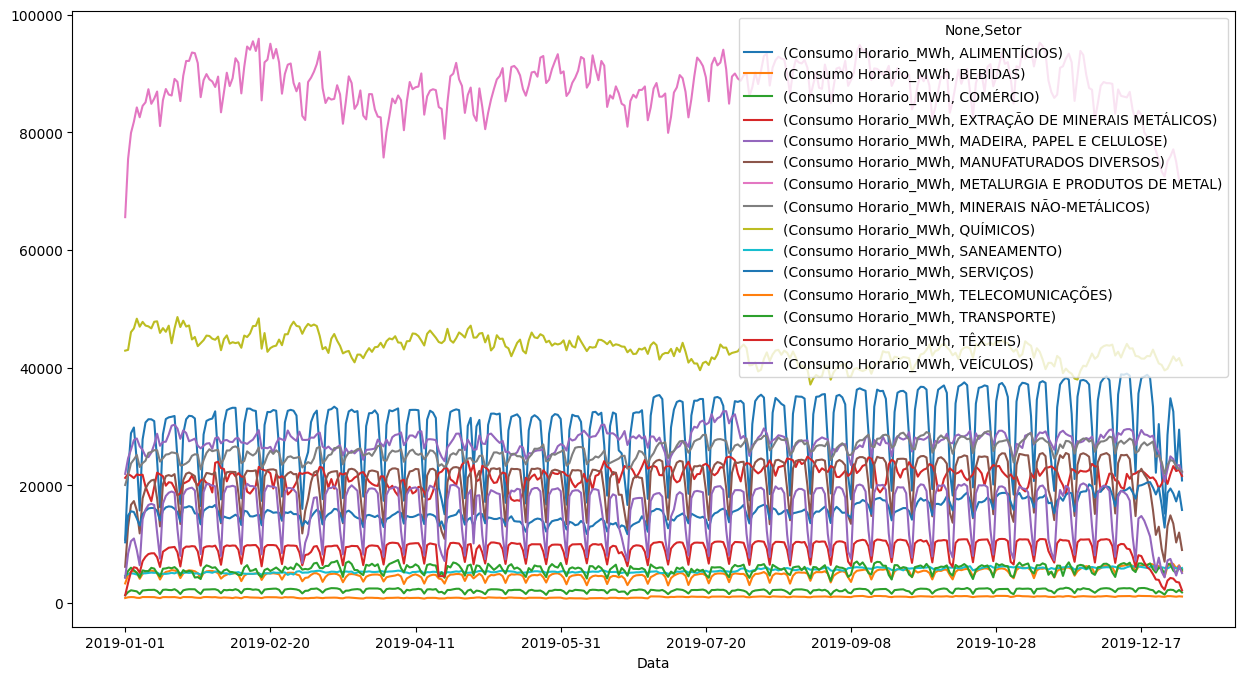

In [16]:
ax = consumo_setor.pivot(columns='Setor',index='Data')
ax.plot(figsize=(15,8))


Iniciando etapa para remoção dos outliers baseado na Capacidade de Carga dos agentes.

In [18]:
q1 = df_ml['Capacidade_MW'].quantile(0.25)
q3 = df_ml['Capacidade_MW'].quantile(0.75)
iqr = q3 - q1 #Interquartile range
fence_low  = q3-1.5*iqr
fence_high = q1+1.5*iqr

In [19]:
filtered_df_ml = df_ml[(df_ml['Capacidade_MW'] > fence_low) & (df_ml['Capacidade_MW'] < fence_high)]

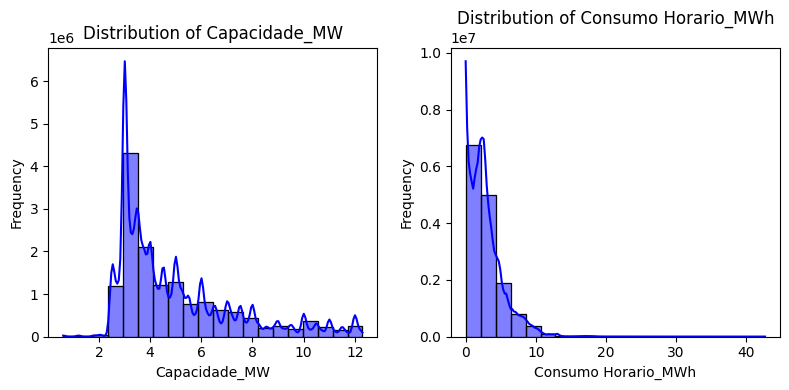

In [24]:
numerical_cols = ['Capacidade_MW','Consumo Horario_MWh']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
  sns.histplot(filtered_df_ml[col], kde=True, color='blue', bins=20, ax=axes[i])
  axes[i].set_title(f"Distribution of {col}")
  axes[i].set_xlabel(col)
  axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x7be2a4067a90>,
 'caps': [<matplotlib.lines.Line2D at 0x7be285c88d00>,
 'boxes': [<matplotlib.lines.Line2D at 0x7be2a4065fc0>],
 'medians': [<matplotlib.lines.Line2D at 0x7be285c8b2b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7be285c8b460>],
 'means': []}

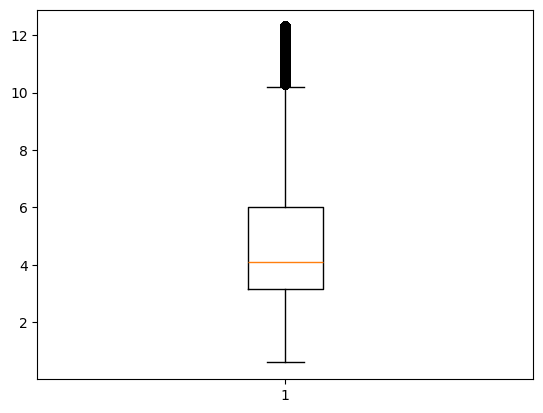

In [ ]:
plt.boxplot(filtered_df_ml['Capacidade_MW'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7be272079ba0>,
 'caps': [<matplotlib.lines.Line2D at 0x7be27207b850>,
 'boxes': [<matplotlib.lines.Line2D at 0x7be27207a500>],
 'medians': [<matplotlib.lines.Line2D at 0x7be27207b670>],
 'fliers': [<matplotlib.lines.Line2D at 0x7be27207a260>],
 'means': []}

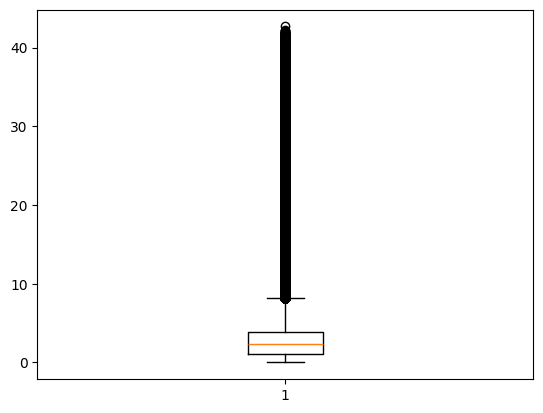

In [ ]:
plt.boxplot(filtered_df_ml['Consumo Horario_MWh'])

<ipython-input-80-aa345ade0bf6>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=filtered_df_ml['Setor'], y=filtered_df_ml['Consumo Horario_MWh'], palette="Set3",)
<ipython-input-80-aa345ade0bf6>:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)


[Text(0, 0, 'SERVIÇOS'),
 Text(1, 0, 'ALIMENTÍCIOS'),
 Text(2, 0, 'MANUFATURADOS DIVERSOS'),
 Text(3, 0, 'METALURGIA E PRODUTOS DE METAL'),
 Text(4, 0, 'COMÉRCIO'),
 Text(5, 0, 'MINERAIS NÃO-METÁLICOS'),
 Text(6, 0, 'BEBIDAS'),
 Text(7, 0, 'TÊXTEIS'),
 Text(8, 0, 'MADEIRA, PAPEL E CELULOSE'),
 Text(9, 0, 'QUÍMICOS'),
 Text(10, 0, 'SANEAMENTO'),
 Text(11, 0, 'EXTRAÇÃO DE MINERAIS METÁLICOS'),
 Text(12, 0, 'TRANSPORTE'),
 Text(13, 0, 'VEÍCULOS'),
 Text(14, 0, 'TELECOMUNICAÇÕES')]

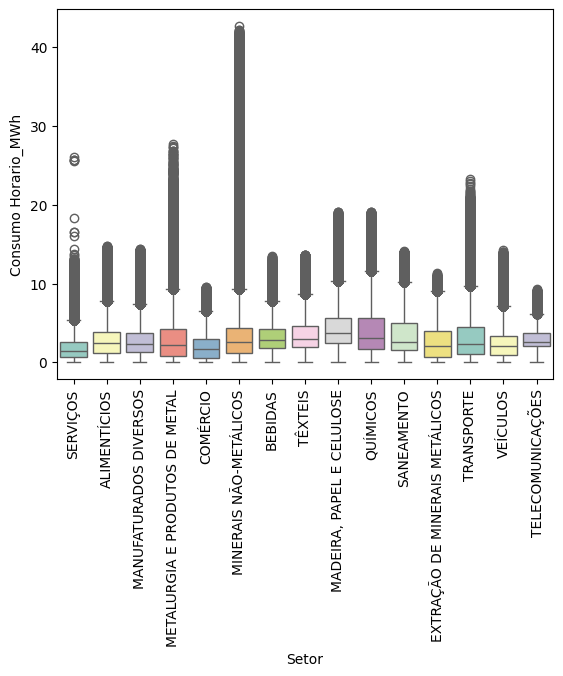

In [ ]:
ax = sns.boxplot(x=filtered_df_ml['Setor'], y=filtered_df_ml['Consumo Horario_MWh'], palette="Set3",)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)